# Pycnocline depth and variance calculations comparisons in models and observations

** Summary: **
Compute pycnocline depth as first moment of temperature stratification. Compare timeseries and variance quantities between observations and different model configurations.

** Problems/To do **
* Should relabel 'temp_mod' to 'temp' since the obs data is also stored in this array
* Change ii and jj to iconf and iloc to better represent configuration and location indices.

** Notebook: ** pycnocline_virtual_moorings.ipynb

** Author: ** jelt 7 Nov 2016

** Changelog: **
* 7 Nov 2016: get started from jelt script peanom.ipynb
* 25 Nov 2016: Move all function calls to unique copy in amm60_data_tools.py
* 26 Nov 2016: Running mean 3 day filtering. Clip variance values where delta_nt not defined
* 27 Nov 2016: Output key figures to file. Shift working code to py file. Changed name from pycnocline_mod_obs_virtual_moorings.ipynb 

$$\delta = H (T_b - T_{bar}) / (T_{top} - T_b)$$ is the expression used.
Where does this come from?

For a two layer fluid
$$T_{bar} = (h_{top} T_{top} + h_{bot} T_{bot})/H $$
Therefore
$$H T_{bar} = \delta T_{top} + (H-\delta) T_{bot} $$



$$ \delta = H (T_{bar} - T_{bot}) / (T_{top} - T_{bot} )   $$

In [53]:
#%%writefile pycnocline_virtual_moorings.py
# %load pycnocline_virtual_moorings.py
#
# pycnocline_virtual_moorings.py
#
# Diagnostics of pycnocline depth and std for model and observed virtual moorings.
# Compares NNA, AMM7, AMM60 models.
#
# Origin: pycnocline_virtual_moorings.ipynb
# jpolton 27/11/16

from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy 
#import AMM60_tools
#from amm60_data_tools import NEMO_fancy_datestr
#from amm60_data_tools import doodsonX0
from amm60_data_tools import delta_diagnose
from amm60_data_tools import readMODELnc
%matplotlib inline

from __future__ import division

# Global constants
time_origin = '1950-01-01 00:00:00'
dstart = datetime.datetime(2012,6,10) # For plotting
dend = datetime.datetime(2012,7,3)

#dirname = '/Users/jeff/GitHub/AMM60_paper/Programs/FASTNEt/' # Set path structure for files
dirname = '../FASTNEt/' # Set path structure for files

locations = ['ST1','ST2','ST4','ST5','SE']
configurations = ['NNA','AMM60','AMM7','obs'] # Note the observational data is in each config file, except NNA

# The observational data is extracted from the last config file loaded
# Load the data and map each location to the axis 1 and config to axis 2
# e.g. temp_mod[time, location, config]
labels =   [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
temp_mod = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
temp_obs = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
delta    = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
delta_nt = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
internal_tide_map = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
internal_tide_map_3day = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
pycn_depth_map    = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
pycn_depth_map_3day    = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
depth        = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_str = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_counter = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_counter_3day = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_datetime = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_datetime_3day = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
print 'Really need a better way to define the "empty" variables...'


for jj in range(len(locations)):
    dz = []
    if (locations[jj] == 'SE'):
        max_depth = 100 # This is a fix for a bug in the moorings files not in the NEMO output
    else:
        max_depth = 150

    for ii in range(len(configurations)-1): # Exclude looping over 'obs' since these data are not in a separate file but embedded in model files.
        path = dirname+'Moorings_'+configurations[ii]+'/' 
        filename = path+'mooring_'+locations[jj]+'.nc'

        labels[jj][ii] = str(locations[jj])+'_'+str(configurations[ii])

        depth[jj][ii] = readMODELnc(filename,'depth')
        time_counter[jj][ii] = readMODELnc(filename,'time')*24*3600
#        temp_obs[jj][ii] = readMODELnc(filename,'temp_obs')
        temp_mod[jj][ii] = readMODELnc(filename,'temp_mod')
    
        # Get the pycnocline depth and variance quantities
        [ delta[jj][ii], delta_nt[jj][ii], internal_tide_map[jj][ii], time_datetime[jj][ii],  pycn_depth_map_3day[jj][ii], internal_tide_map_3day[jj][ii], time_datetime_3day[jj][ii], time_counter_3day[jj][ii] ] = delta_diagnose( temp_mod[jj][ii], time_counter[jj][ii], depth[jj][ii], max_depth )


        
        # Add diagnostics for the observational data. ii=3. These are reproduced in each model config run but only populate variable for config ii=2
        if (configurations[ii] == 'AMM7'): 
            ii_obs = configurations.index("obs")
            labels[jj][ii_obs] = str(locations[jj])+'_'+'obs'
            temp_mod[jj][ii_obs] = readMODELnc(filename,'temp_obs')
            depth[jj][ii_obs] = readMODELnc(filename,'depth')
            time_counter[jj][ii_obs] = deepcopy(time_counter[jj][ii])
            #time_datetime[jj][ii_obs] = deepcopy(time_datetime[jj][ii])
            
            [delta[jj][ii_obs], delta_nt[jj][ii_obs], internal_tide_map[jj][ii_obs], time_datetime[jj][ii_obs],  pycn_depth_map_3day[jj][ii_obs], internal_tide_map_3day[jj][ii_obs], time_datetime_3day[jj][ii_obs], time_counter_3day[jj][ii_obs]] = delta_diagnose( temp_mod[jj][ii_obs], time_counter[jj][ii_obs], depth[jj][ii_obs], max_depth )

            """
            In the observational data there are nans that mess things up with the diagnostics.
            Mask out all pycnocline mean and variance values when delta_nt is not defined.
            """ 
            #Find first non-nan delta_nt time
            ind = []
            ind = np.where(~np.isnan(delta_nt[jj][ii_obs]))
            
            start_counter = time_datetime[jj][ii_obs][ind[0][0]]
            end_counter = time_datetime[jj][ii_obs][ind[0][-1]]
            
            internal_tide_map_3day[jj][ii_obs][ np.where(time_datetime_3day[jj][ii_obs]<start_counter)] = np.nan
            internal_tide_map_3day[jj][ii_obs][ time_datetime_3day[jj][ii_obs]>  end_counter ] = np.nan
            
            pycn_depth_map_3day[jj][ii_obs][ time_datetime_3day[jj][ii_obs][:]<start_counter ] = np.nan
            pycn_depth_map_3day[jj][ii_obs][ time_datetime_3day[jj][ii_obs][:]>  end_counter ] = np.nan


# PLOTS
#######
# Plot pyncocline depth and variance for each configuration at each location

alph = ['a)','b)','c)','d)','e)'] # figure panel letters
col_list = ['green','red','blue','black']
fig = plt.figure(figsize=(15,15))
for jj in range(len(locations)):
    for ii in range(len(configurations)):
        # Pycnocline depth
        ax1 = fig.add_subplot(len(locations),1,jj+1)


        ax1.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:],color=col_list[ii],label=labels[jj][ii])
        ax1.set_ylabel('pycnocline depth (m), solid')
        if (locations[jj] == 'SE'):
            ax1.set_xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
            ax1.legend(configurations,loc='lower right') # Only have legend for last plot
        else:
            ax1.set_xlim([dstart,dend])
        ax1.set_ylim([-70, 0])
        # Add location text
        start = ax1.get_xlim()[0] + 0.2
        ax1.text(start, -60, alph[jj]+' '+locations[jj])
        
        ax2 = ax1.twinx()   # mirror them
        # Pycnocline depth sqrt(variance)
        ax2.plot(time_datetime_3day[jj][ii],-np.sqrt(internal_tide_map_3day[jj][ii][:]),'--',color=col_list[ii])  
        ax2.set_ylabel('pycnocline std (m), dashed')
        if (locations[jj] == 'SE'):
            ax2.set_xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
        else:
            ax2.set_xlim([dstart,dend])
        ax2.set_ylim([-11, 0])

## Save output
###############################
fname = 'pycnocline_virtual_moorings_stats.png'
plt.savefig(fname)





# Plot locations for fixed configurations
# ii: [0->NNA, 1->AMM60, 2->AMM7, 3->obs]
ii = 3 
print([labels[kk][ii] for kk in range(len(locations))])

fig = plt.figure(figsize=(15,15)) 
for jj in range(len(locations)):
    fig.add_subplot(len(locations),1,jj+1)
    plt.pcolormesh(time_datetime[jj][ii],-depth[jj][ii],temp_mod[jj][ii])
    plt.clim([11,15.5])
    plt.title(labels[jj][ii])
    if (locations[jj] == 'SE'):
        plt.xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
        plt.ylim([-200, 0])
    else:
        plt.xlim([dstart,dend])
        plt.ylim([-200, 0])
    plt.colorbar()
    
    plt.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:],'b-')
    plt.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:]+np.sqrt(internal_tide_map_3day[jj][ii][:]),'r-')
    plt.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:]-np.sqrt(internal_tide_map_3day[jj][ii][:]),'r-')
    plt.plot(time_datetime[jj][ii], -delta[jj][ii][:], 'g')
    plt.plot(time_datetime[jj][ii], -delta_nt[jj][ii][:], 'k')

## Save output
###############################
fname = 'pycnocline_virtual_moorings_obs_stats.png'
plt.savefig(fname)

Writing pycnocline_virtual_moorings.py


In [4]:
print locations

['ST1', 'ST2', 'ST4', 'ST5', 'SE']


['SE_NNA', 'SE_AMM60', 'SE_AMM7', 'SE_obs']


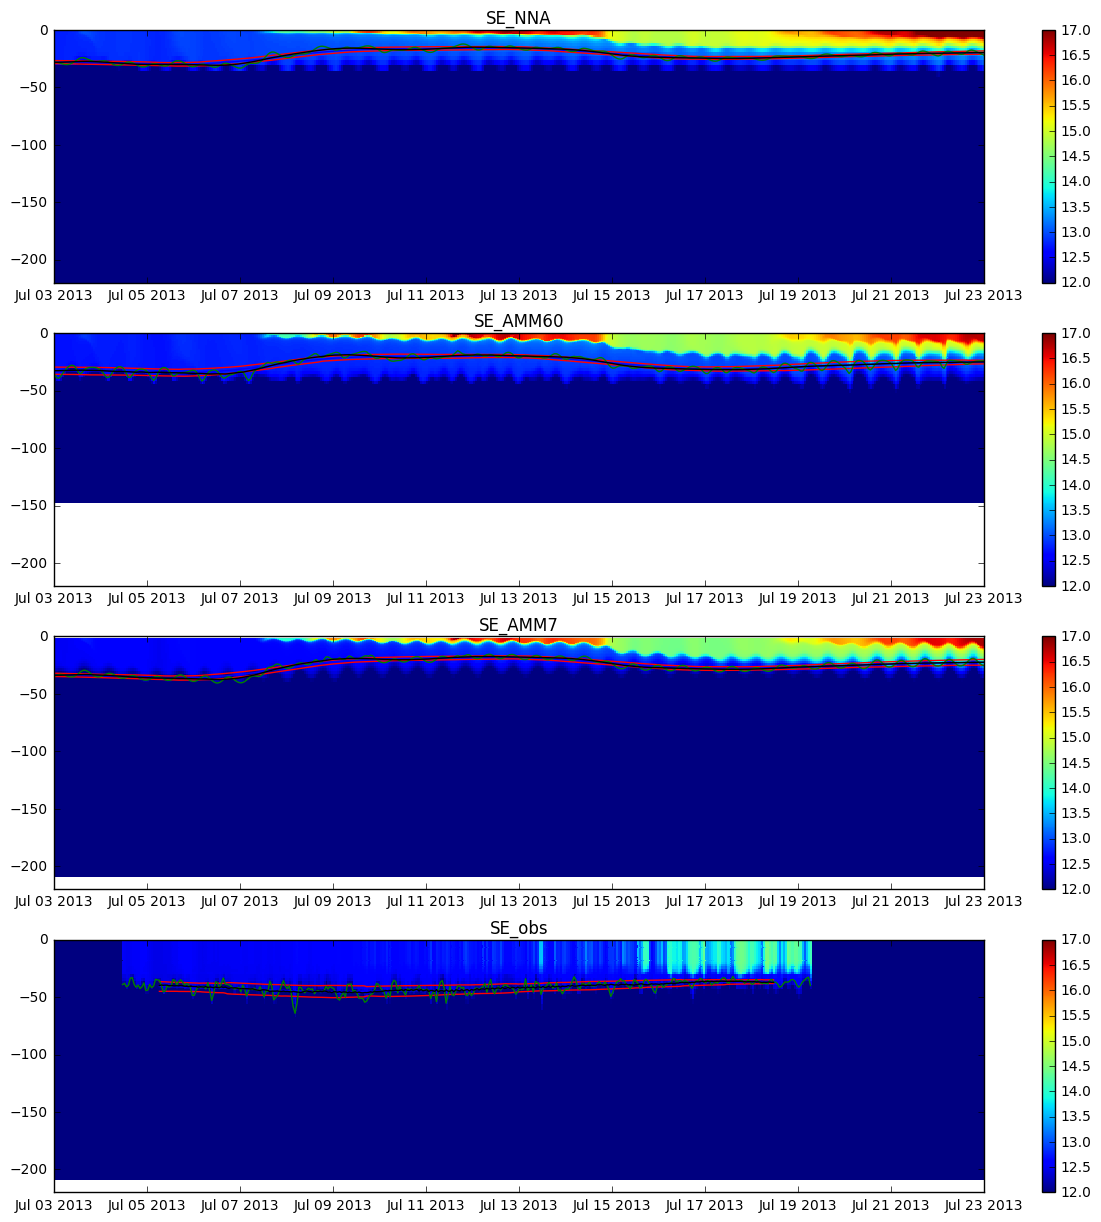

In [35]:
# Plot Configurations at fixed location
jj = 4
print labels[jj][:]
fig, ax = plt.subplots(4,1)
plt.rcParams['figure.figsize'] = (15.0, 15.0) 
for ii in range(len(labels[0])):
    plt.subplot(4,1,ii+1)
    plt.pcolormesh(time_datetime[jj][ii],-depth[jj][ii],temp_mod[jj][ii])
    plt.clim([5.5,15.5])
    plt.ylim([-220, 0])
    if (locations[jj] == 'SE'):
        plt.xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
    else:
        plt.xlim([dstart,dend])
    plt.clim([12,17])
    plt.title(labels[jj][ii])
    plt.colorbar()
    
    plt.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:],'b-')
    plt.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:]+np.sqrt(internal_tide_map_3day[jj][ii][:]),'r-')
    plt.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:]-np.sqrt(internal_tide_map_3day[jj][ii][:]),'r-')
    plt.plot(time_datetime[jj][ii], -delta[jj][ii][:], 'g')
    plt.plot(time_datetime[jj][ii], -delta_nt[jj][ii][:], 'k')    
    

In [5]:
print configurations

['NNA', 'AMM60', 'AMM7', 'obs']


['ST1_obs', 'ST2_obs', 'ST4_obs', 'ST5_obs', 'SE_obs']


/Users/jeff/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


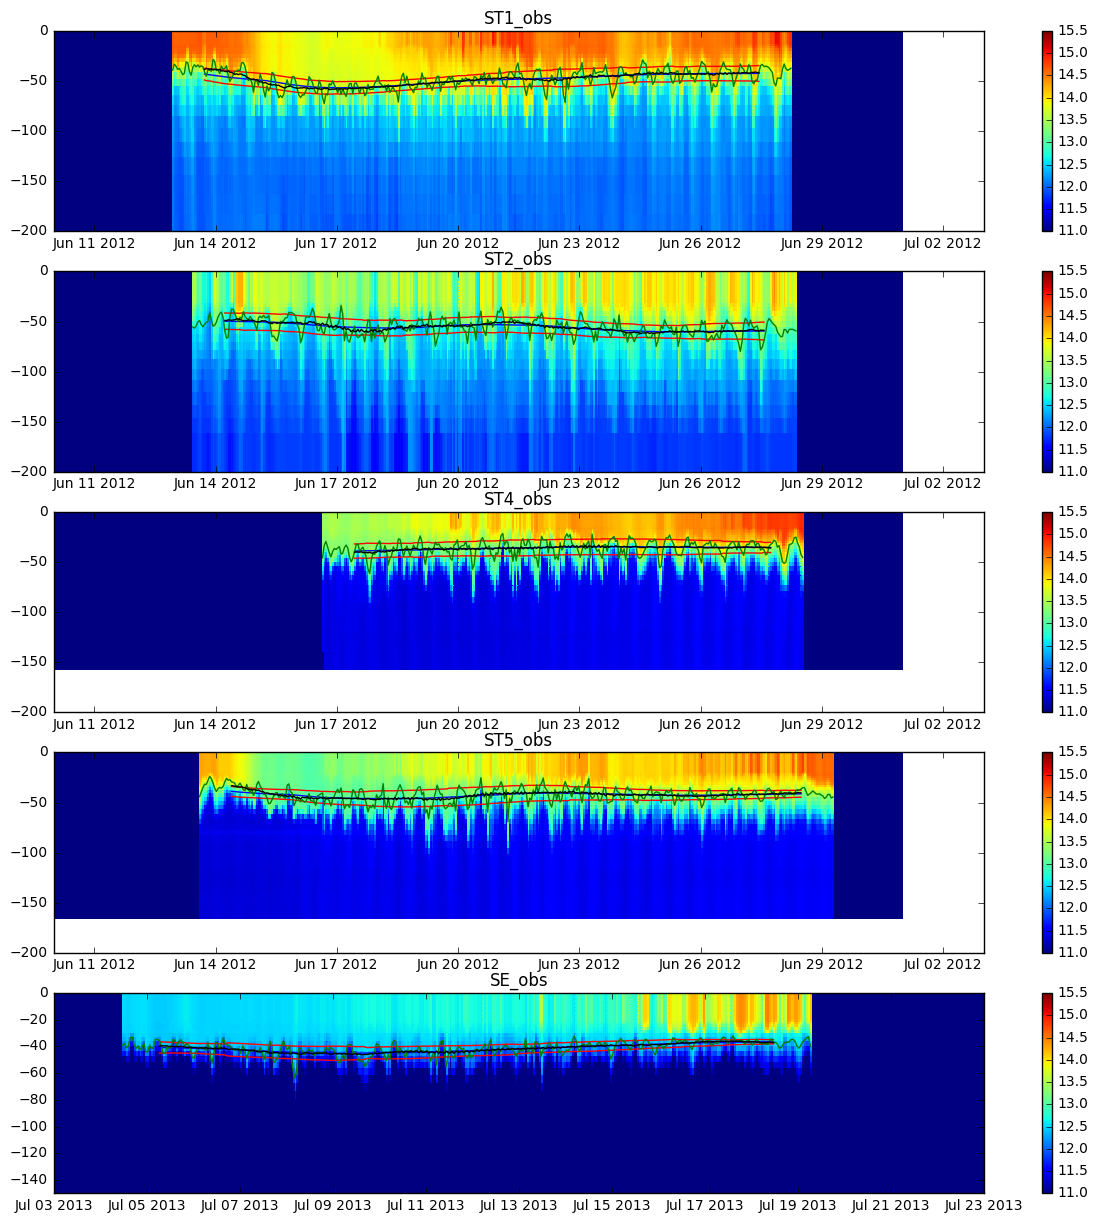

In [46]:
# Plot locations for fixed configurations
ii = 3
print([labels[kk][ii] for kk in range(len(locations))])

fig, ax = plt.subplots(len(locations),1)
plt.rcParams['figure.figsize'] = (15.0, 15.0) 
for jj in range(len(locations)):
    plt.subplot(len(locations),1,jj+1)
    plt.pcolormesh(time_datetime[jj][ii],-depth[jj][ii],temp_mod[jj][ii])
    plt.clim([11,15.5])
    plt.title(labels[jj][ii])
    if (locations[jj] == 'SE'):
        plt.xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
        plt.ylim([-200, 0])
    else:
        plt.xlim([dstart,dend])
        plt.ylim([-200, 0])
    plt.colorbar()
    
    plt.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:],'b-')
    plt.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:]+np.sqrt(internal_tide_map_3day[jj][ii][:]),'r-')
    plt.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:]-np.sqrt(internal_tide_map_3day[jj][ii][:]),'r-')
    plt.plot(time_datetime[jj][ii], -delta[jj][ii][:], 'g')
    plt.plot(time_datetime[jj][ii], -delta_nt[jj][ii][:], 'k')



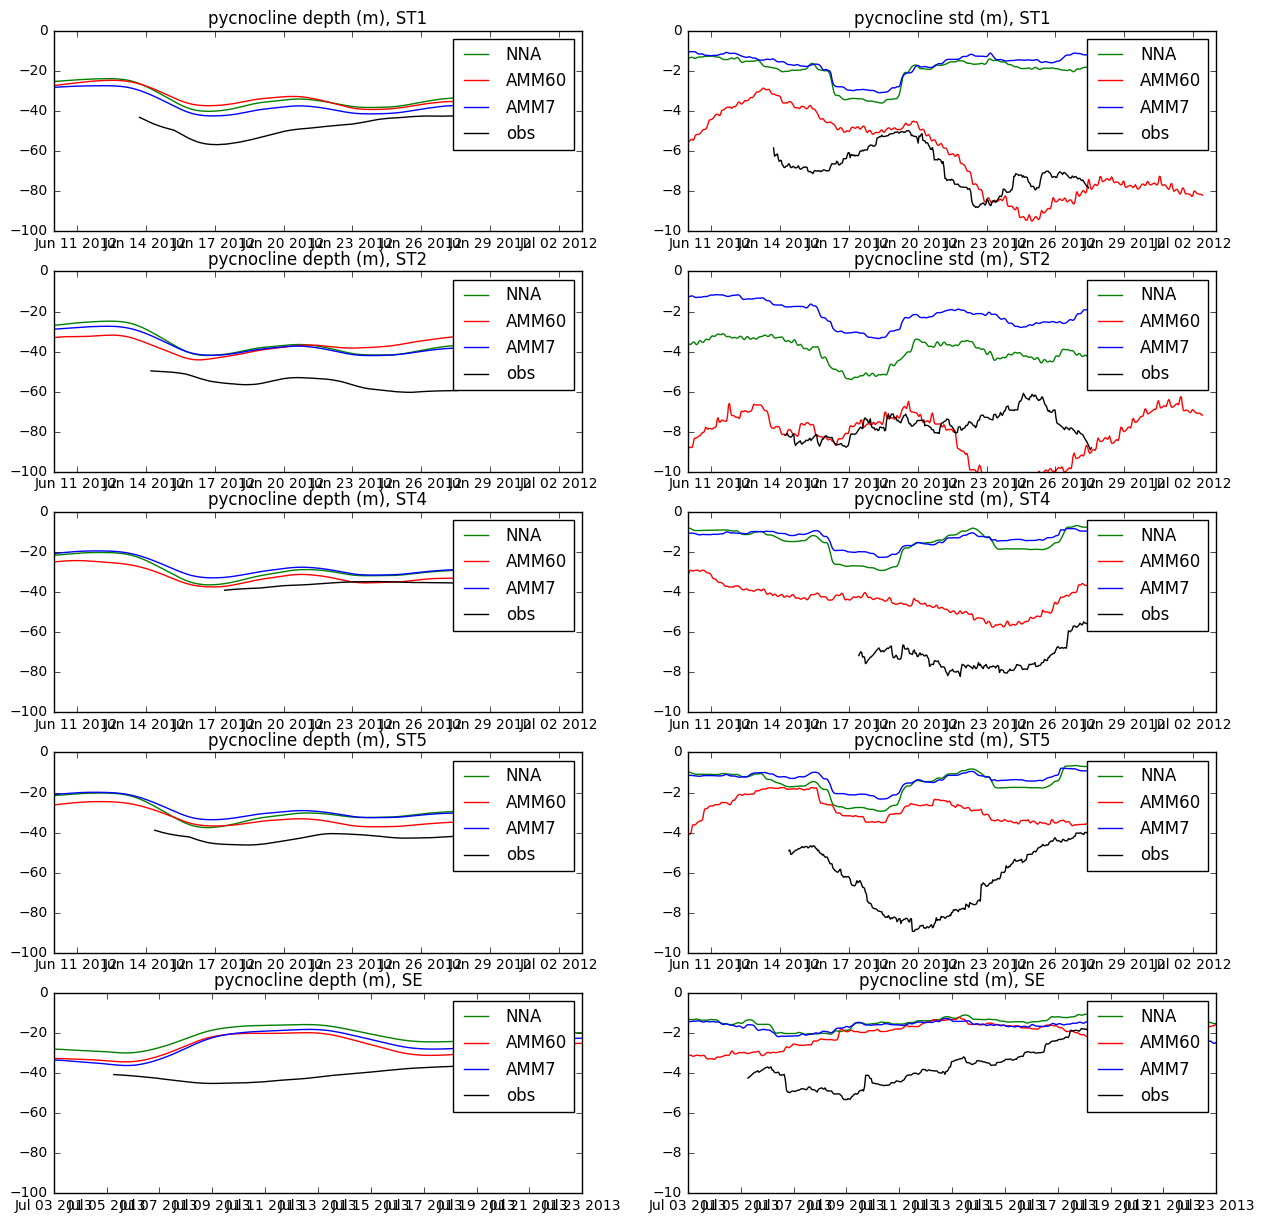

In [47]:
# Plot pyncocline depth and variance for each configuration at each location

# Separate subplots for pycnocline depth and std

col_list = ['green','red','blue','black']
fig, ax = plt.subplots(len(locations),2)
plt.rcParams['figure.figsize'] = (15.0, 15.0) 
#for jj in range(1):
for jj in range(len(locations)):
    for ii in range(len(configurations)):
        # Pycnocline depth
        plt.subplot(len(locations),2,2*jj+1)    
        plt.plot(time_datetime_3day[jj][ii],-pycn_depth_map_3day[jj][ii][:],color=col_list[ii],label=labels[jj][ii])
        plt.title('pycnocline depth (m), '+locations[jj])
        if (locations[jj] == 'SE'):
            plt.xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
        else:
            plt.xlim([dstart,dend])
        plt.ylim([-100, 0])
        plt.legend(configurations)
        
        # Pycnocline depth sqrt(variance)
        plt.subplot(len(locations),2,2*jj+2)    
        plt.plot(time_datetime_3day[jj][ii],-np.sqrt(internal_tide_map_3day[jj][ii][:]),color=col_list[ii])  
        plt.title('pycnocline std (m), '+locations[jj])
        if (locations[jj] == 'SE'):
            plt.xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
        else:
            plt.xlim([dstart,dend])
        plt.ylim([-10, 0])
        plt.legend(configurations)

